# Image compression (Lossy)

---

We will see how we can compress an image dataset, reducing the number of components needed to represent each image. But loosing some information in the process.

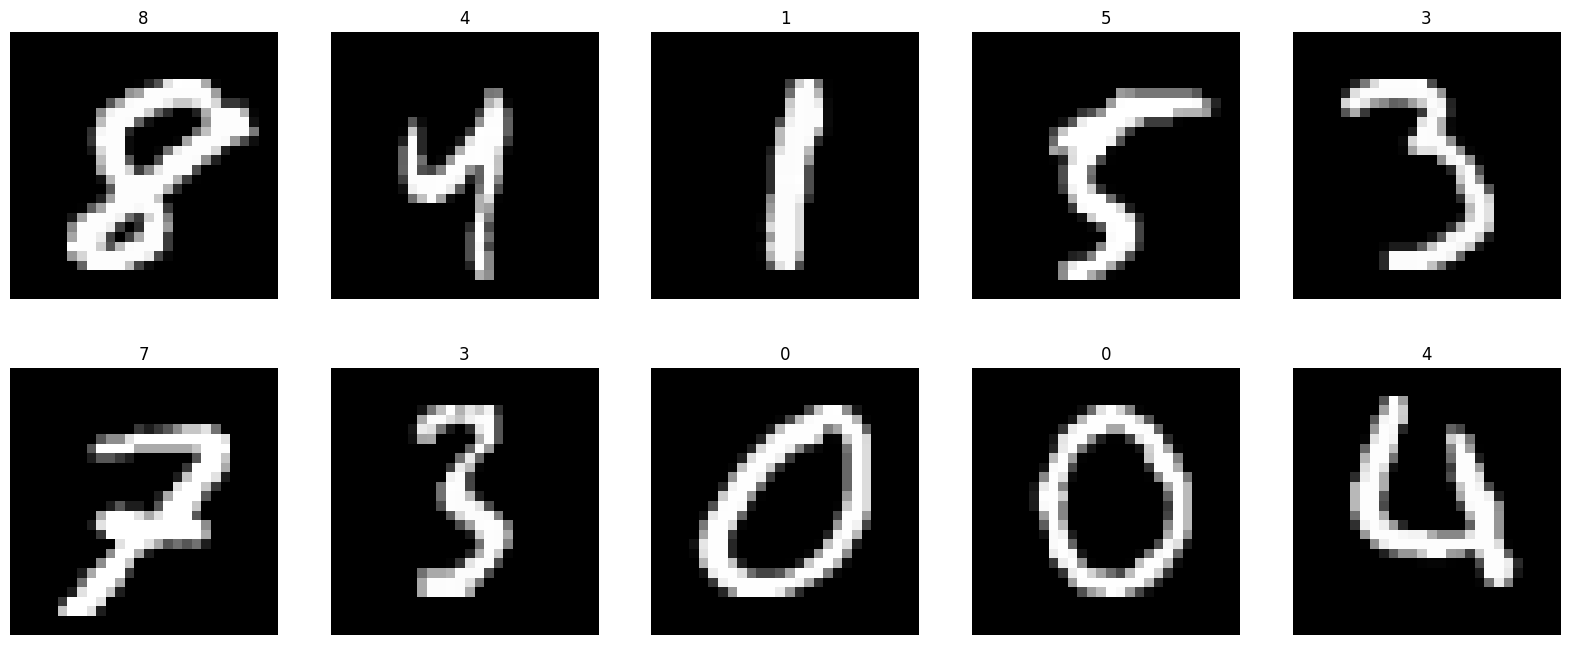

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow
import numpy as np

dataset = 'mnist'  # 'cifar10'

def plot_sample(imgs, labels, nrows, ncols, resize=None, tograyscale=False, shuffle=True):
    # create a grid of images
    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    # take a random sample of images
    if shuffle:
        indices = np.random.choice(len(imgs), size=nrows*ncols, replace=False)
    else:
        indices = np.arange(nrows*ncols)
    for ax, idx in zip(axs.reshape(-1), indices):
        ax.axis('off')
        # sample an image
        ax.set_title(labels[idx])
        im = imgs[idx]
        if isinstance(im, np.ndarray):
            im = Image.fromarray(im)  
        if resize is not None:
            im = im.resize(resize)
        if tograyscale:
            im = im.convert('L')
        ax.imshow(im, cmap='gray')
    plt.show()

# Load the data
if dataset == 'mnist':
  from tensorflow.keras.datasets import mnist
  (x_train, y_train), _ = mnist.load_data()
elif dataset == 'cifar10':
  from tensorflow.keras.datasets import mnist, cifar10
  (x_train, y_train), _ = cifar10.load_data()
  (x_train, y_train) = (x_train.mean(-1), y_train.mean(-1))  # grayscale

plot_sample(x_train, y_train, 2, 5)

Vectorize the images.

In [3]:
n_samples = 60000
x_train, y_train = x_train[:n_samples], y_train[:n_samples]
print("x_train:", x_train.shape) 

# Reshape to vectors and rescale to [0, 1]
w, h = x_train.shape[1:3]
X = x_train.reshape(-1, w * h) /255.
print("X:", X.shape)

x_train: (60000, 28, 28)
X: (60000, 784)


Let's plot the principal components.

In [17]:
from sklearn.decomposition import PCA

# Zero mean
X_mean = X.mean(axis=0, keepdims=True)
X0 = X - X_mean 

# PCA
n_components = 98
pca = PCA(n_components=n_components)
pca.fit(X0)

PCA(n_components=98)

Original images


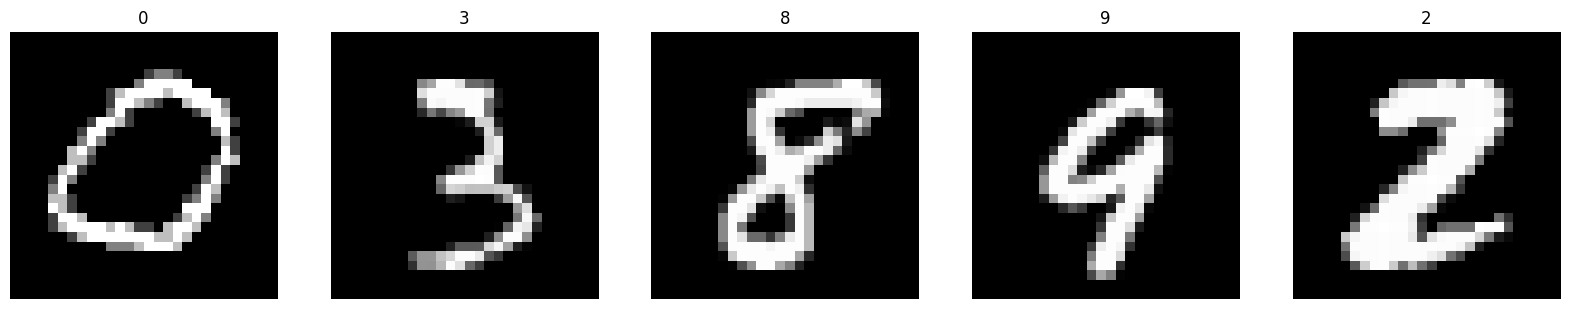

Reconstructed images


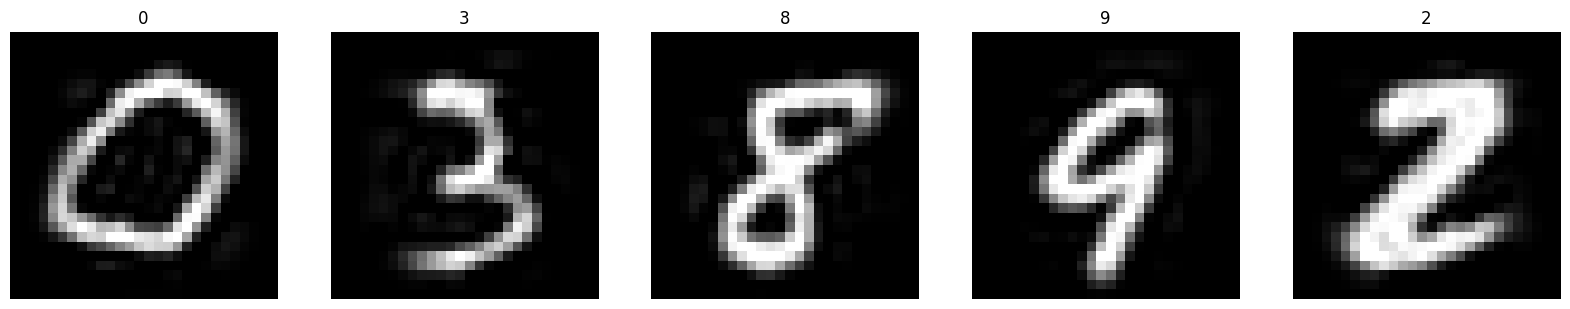

In [18]:
# compress
X_red = pca.transform(X0)
# extract
X_rec = pca.inverse_transform(X_red)
X_rec += X_mean

# reshape to image size and range
x_image_rec = 255 * X_rec.clip(0, 1).reshape(-1, w, h)
x_image_orig = 255 * X.clip(0, 1).reshape(-1, w, h)

# draw some random images
p = np.random.choice(X.shape[0], size=5)
print("Original images")
plot_sample(x_image_orig[p], y_train[p], 1, 5, shuffle=False)
print("Reconstructed images")
plot_sample(x_image_rec[p], y_train[p], 1, 5, shuffle=False)

The original images are 28x28 pixels, so they live in a 784-dimensional space. 

The compressed images live in a 98-dimensional space.

**We can store more than 8x as many images in the same space!**

**We can send the compressed images over the network 8x as fast!**

# Image denoising

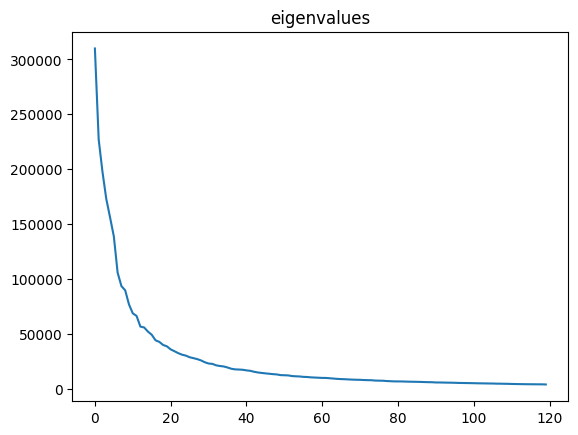

Original images


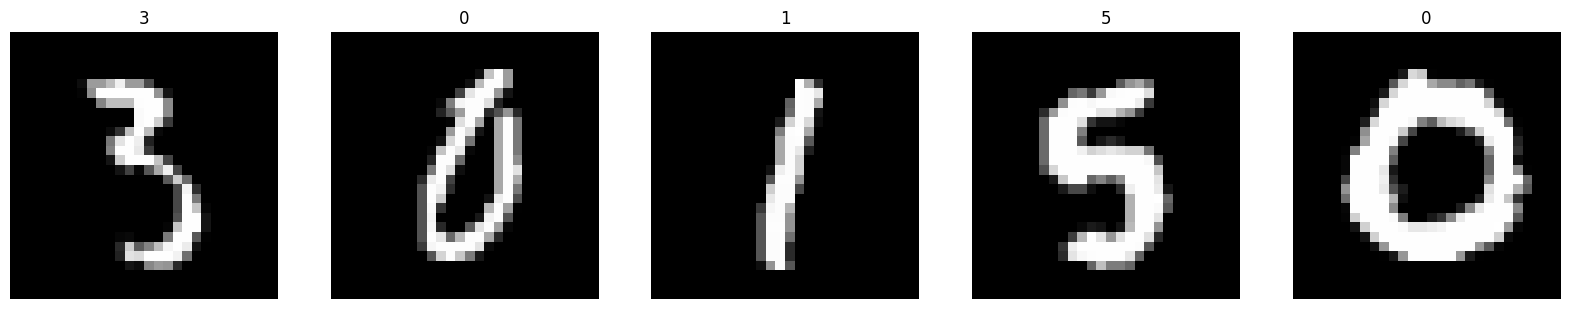

Noisy images


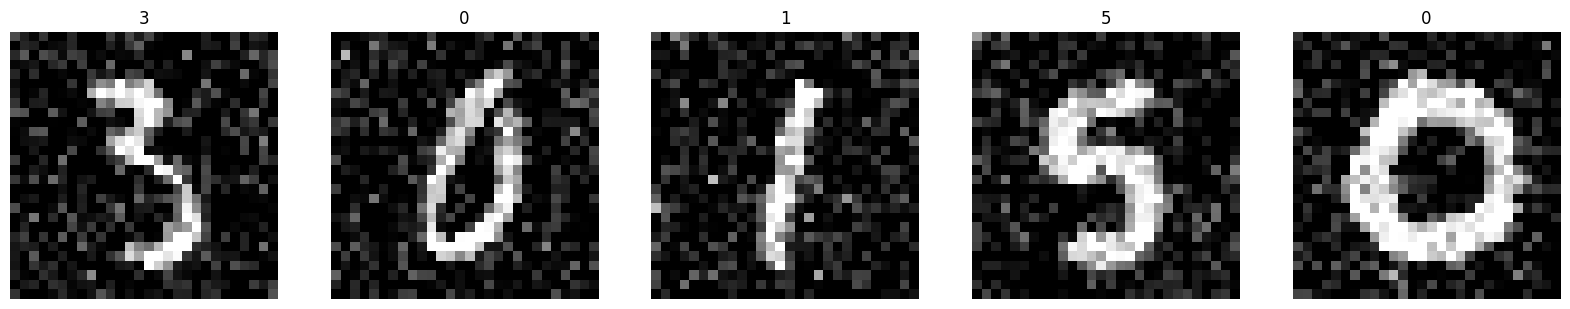

Reconstructed images


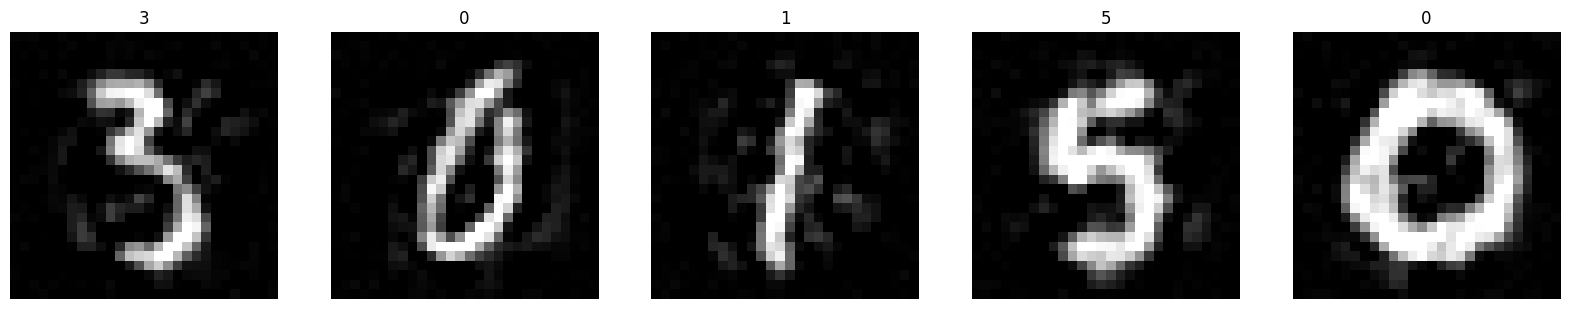

In [22]:
# Add noise to X
X_noisy = X + np.random.randn(*X.shape)*.2

# PCA
n_components = 120
X_mean = X_noisy.mean(axis=0, keepdims=True)
X0 = X_noisy - X_mean 
pca = PCA(n_components=n_components)
pca.fit(X0)

# compress
X_red = pca.transform(X0)
# extract
X_rec = pca.inverse_transform(X_red)
X_rec += X_mean

# reshape to image size and range
x_image_orig = 255 * X.clip(0, 1).reshape(-1, w, h)
x_image_noisy = 255 * X_noisy.clip(0, 1).reshape(-1, w, h)
x_image_rec = 255 * X_rec.clip(0, 1).reshape(-1, w, h)

# draw some random images
p = np.random.choice(X.shape[0], size=5)
print("Original images")
plot_sample(x_image_orig[p], y_train[p], 1, 5, shuffle=False)
print("Noisy images")
plot_sample(x_image_noisy[p], y_train[p], 1, 5, shuffle=False)
print("Reconstructed images")
plot_sample(x_image_rec[p], y_train[p], 1, 5, shuffle=False)